# numpy

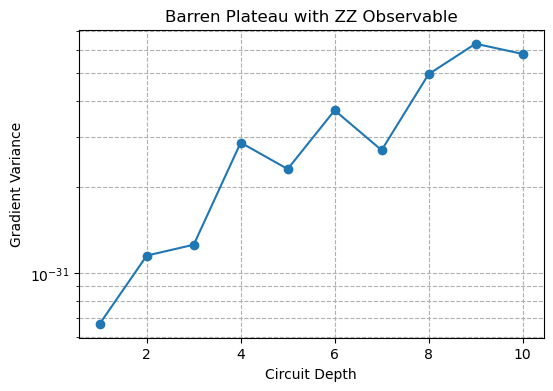

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def rz(theta):
    """Single-qubit RZ rotation."""
    return np.array([[np.exp(-1j*theta/2), 0],
                     [0, np.exp(1j*theta/2)]])

def cx(n, control, target):
    """n-qubit CNOT gate matrix with given control and target indices."""
    dim = 2**n
    mat = np.zeros((dim, dim), dtype=complex)
    for i in range(dim):
        b = [(i >> j) & 1 for j in range(n)]
        j = i
        if b[control] == 1:
            b[target] ^= 1
            j = sum(bit << idx for idx, bit in enumerate(b))
        mat[j, i] = 1
    return mat

def random_circuit(n, depth, thetas):
    """Build n-qubit circuit: alternating RZ layers and chain of CNOTs."""
    dim = 2**n
    U = np.eye(dim, dtype=complex)
    idx = 0
    for _ in range(depth):
        # RZ on each qubit
        for q in range(n):
            U = U @ np.kron(np.eye(2**q),
                            np.kron(rz(thetas[idx]),
                                    np.eye(2**(n-q-1))))
            idx += 1
        # entangle in a line
        for q in range(n-1):
            U = cx(n, q, q+1) @ U
    return U

def build_ZZ_operator(n):
    """Construct M = sum_{i=0}^{n-2} Z_i Z_{i+1}."""
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    M = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n-1):
        # 构造 Z_i Z_{i+1}
        op = 1
        for q in range(n):
            if q == i or q == i+1:
                op = np.kron(op, Z)
            else:
                op = np.kron(op, np.eye(2, dtype=complex))
        M += op
    return M


def expectation(U, M):
    """Expectation value of observable M under U|0...0>."""
    psi0 = np.zeros(2**int(np.log2(M.shape[0])), dtype=complex)
    psi0[0] = 1  # |00...0>
    psi = U @ psi0
    return np.real(np.vdot(psi, M @ psi))

def parameter_shift_grad(n, depth, thetas, idx, M, shift=np.pi/2):
    """Parameter-shift rule for gradient on one parameter idx."""
    thetas_p = thetas.copy()
    thetas_m = thetas.copy()
    thetas_p[idx] += shift
    thetas_m[idx] -= shift
    U_p = random_circuit(n, depth, thetas_p)
    U_m = random_circuit(n, depth, thetas_m)
    return (expectation(U_p, M) - expectation(U_m, M)) / 2

# 主程序：统计不同深度下梯度方差
n_qubits = 4
depths = np.arange(1, 11)
samples = 50

# 预先构造 ZZ 观测算符 M
M = build_ZZ_operator(n_qubits)

variances = []
for d in depths:
    grads = []
    for _ in range(samples):
        thetas = np.random.uniform(0, 2*np.pi, n_qubits * d)
        g = parameter_shift_grad(n_qubits, d, thetas, idx=2, M=M)
        grads.append(g)
        # print(g)
    variances.append(np.var(grads))

# 绘图
plt.figure(figsize=(6,4))
plt.plot(depths, variances, marker='o')
plt.yscale('log')
plt.xlabel('Circuit Depth')
plt.ylabel('Gradient Variance')
plt.title('Barren Plateau with ZZ Observable')
plt.grid(True, which='both', ls='--')
plt.show()


# qiskit

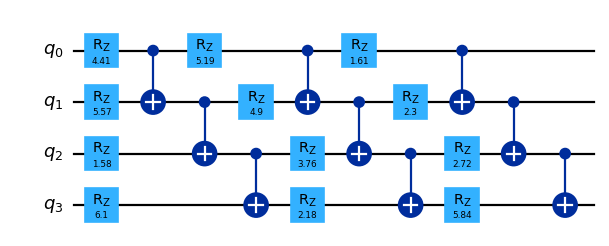

In [46]:
from qiskit import QuantumCircuit, transpile
import numpy as np

# Parameters
n_qubits = 4
depth = 3
thetas = np.random.uniform(0, 2*np.pi, n_qubits * depth)

# Build the Qiskit circuit
qc = QuantumCircuit(n_qubits)
idx = 0
for _ in range(depth):
    # RZ on each qubit
    for q in range(n_qubits):
        qc.rz(thetas[idx], q)
        idx += 1
    # entangle in a line
    for q in range(n_qubits - 1):
        qc.cx(q, q+1)

# Draw the circuit (Matplotlib)
qc.draw(output='mpl', scale=0.8)


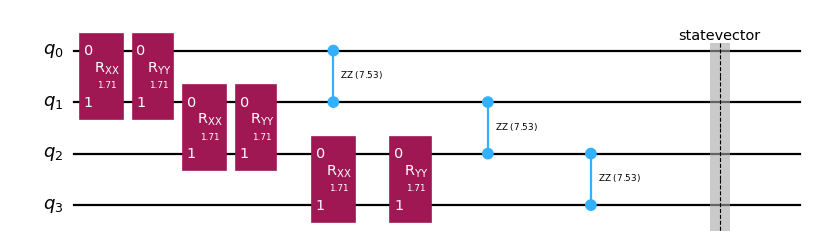

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate

# 构造 XXZ 哈密顿量（NumPy 矩阵）
def build_xxz_hamiltonian(n, delta):
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n-1):
        op_xx = op_yy = op_zz = 1
        for q in range(n):
            if q == i or q == i+1:
                op_xx = np.kron(op_xx, X)
                op_yy = np.kron(op_yy, Y)
                op_zz = np.kron(op_zz, Z)
            else:
                op_xx = np.kron(op_xx, np.eye(2))
                op_yy = np.kron(op_yy, np.eye(2))
                op_zz = np.kron(op_zz, np.eye(2))
        H += op_xx + op_yy + delta * op_zz
    return H

# 构造 XXZ HVA 电路
def build_xxz_hva(n, depth, params, delta):
    qc = QuantumCircuit(n)
    idx = 0
    for _ in range(depth):
        alpha, beta = params[idx], params[idx+1]
        idx += 2
        for i in range(n-1):
            qc.append(RXXGate(2*alpha), [i, i+1])
            qc.append(RYYGate(2*alpha), [i, i+1])
        for i in range(n-1):
            qc.append(RZZGate(2*beta*delta), [i, i+1])
    qc.save_statevector()
    return qc


# 参数设置
n_qubits = 4
depth    = 1
delta    = 0.8
params   = np.random.uniform(0, 2 * np.pi, 2 * depth)

# 构建电路
qc = build_xxz_hva(n_qubits, depth, params, delta)

# 绘制电路图
qc.draw(output='mpl', scale=0.8)


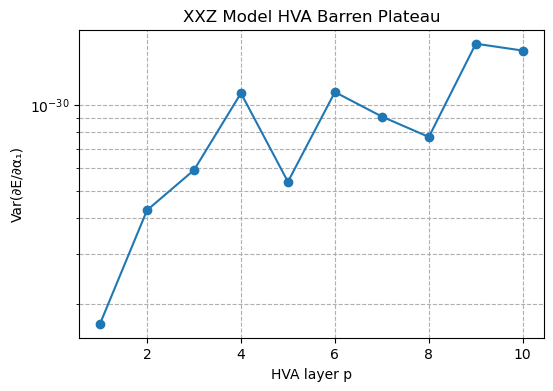

In [54]:


# 用 AerSimulator 计算 <H>，并把 Statevector 转为 NumPy 数组
sim = AerSimulator(method='statevector')

def expectation_value(qc, H):
    # 必要时先 transpile
    qc2 = transpile(qc, sim)
    result = sim.run(qc2).result()
    sv = result.get_statevector()
    psi = np.array(sv)           # 转为 NumPy 数组
    return np.real(psi.conj().T @ (H @ psi))

# 参数移位法计算梯度
def parameter_shift_grad(n, depth, params, delta, H, param_idx):
    shift = np.pi/2
    p_p, p_m = params.copy(), params.copy()
    p_p[param_idx] += shift
    p_m[param_idx] -= shift
    qc_p = build_xxz_hva(n, depth, p_p, delta)
    qc_m = build_xxz_hva(n, depth, p_m, delta)
    e_p = expectation_value(qc_p, H)
    e_m = expectation_value(qc_m, H)
    return 0.5 * (e_p - e_m)

# 主程序：统计不同层数 p 下梯度方差
n_qubits = 4
delta    = 0.8
depths   = np.arange(1, 11)
samples  = 40

H = build_xxz_hamiltonian(n_qubits, delta)
variances = []
for p in depths:
    grads = []
    for _ in range(samples):
        params = np.random.uniform(0, 2*np.pi, 2*p)
        g = parameter_shift_grad(n_qubits, p, params, delta, H, param_idx=1)
        grads.append(g)
    variances.append(np.var(grads))

# 绘图
plt.figure(figsize=(6,4))
plt.plot(depths, variances, 'o-')
plt.yscale('log')
plt.xlabel('HVA layer p')
plt.ylabel('Var(∂E/∂α₁)')
plt.title('XXZ Model HVA Barren Plateau')
plt.grid(which='both', ls='--')
plt.show()
